# Analysing Predictive Power of BoE Speech Sentiment


**Objectives:**
- To explore the impact of BoE speeches on economic indicators (such as GfK Consumer Confidence) especially differentiating between periods of high  market volatility.
- Build a predicitve model for GfK consumer confidence using speech sentiment.



**Context:** Central Bank Communication and Consumer Confidence: Research indicates that the tone and content of central bank communications can significantly influence public perceptions of economic conditions. For instance, a study by Blinder et al. (2008) discusses how the transparency and clarity of central bank messages can shape consumer expectations and, consequently, their confidence in the economy.
Monetary Policy Announcements and Consumer Behaviour: A paper by Campbell et al. (2012) examines how announcements of monetary policy actions, such as interest rate changes, affect consumer sentiment and spending behaviour. The study finds that positive signals from central banks can lead to increased consumer confidence, while negative signals can have the opposite effect.
Speech Sentiment Analysis: Recent advancements in sentiment analysis have enabled researchers to quantify the emotional tone of central bank speeches. For example, a study by Hayo and Neuenkirch (2015) employs sentiment analysis to assess how the language used by the European Central Bank influences financial market expectations and consumer confidence.


**FTSE100 and Volatility Data procedence:** Export from Tradingview (UKX FTSE100 INDEX)
- https://www.tradingview.com/support/solutions/43000589145-historical-volatility/

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


import seaborn as sns
# Set visual style
sns.set(style="whitegrid")

from datetime import datetime

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import os

### User defined functions:

In [2]:
def compute_correlation(sentiment_series, indicator_series, 
                        smoothing_window=None, lag_months=0):
    """
    Compute correlation between sentiment and an indicator.
    
    Parameters:
        sentiment_series (pd.Series): Monthly sentiment time series (datetime index).
        indicator_series (pd.Series): Economic indicator time series (datetime index).
        smoothing_window (int): Rolling window size for sentiment smoothing.
        lag_months (int): Apply lag to indicator (positive = shift indicator forward).
        
    Returns:
        corr (float): Pearson correlation coefficient.
        df_corr (pd.DataFrame): Merged and aligned DataFrame.
    """
    s = sentiment_series.copy()
    i = indicator_series.copy()
    
    if smoothing_window:
        s = s.rolling(window=smoothing_window, min_periods=2, center=True).mean()
    
    if lag_months != 0:
        i = i.shift(-lag_months)  # shift backwards so sentiment leads
    
    df_corr = pd.merge(
        left=s.rename('sentiment'),
        right=i.rename('indicator'),
        left_index=True,
        right_index=True,
        how='inner'
    ).dropna()
    
    corr = df_corr['sentiment'].corr(df_corr['indicator'])
    return corr, df_corr

In [3]:
def test_lag(sentiment_series, indicator_series, 
                              smoothing_window=None, max_lag=24, step=1):
    """
    Compute and display correlation between sentiment and an indicator
    across a range of forward lags.

    Parameters:
        sentiment_series (pd.Series): Monthly sentiment time series.
        indicator_series (pd.Series): Economic indicator time series.
        smoothing_window (int): Optional rolling average window for sentiment.
        max_lag (int): Maximum number of months to test as lag.
        step (int): Step size for lag intervals (e.g. 1, 3, 6).
    
    Returns:
        pd.DataFrame: Table of lag and correlation values.
    """
    results = []

    for lag in range(0, max_lag + 1, step):
        corr, _ = compute_correlation(sentiment_series, indicator_series, 
                                      smoothing_window=smoothing_window, lag_months=lag)
        results.append({'lag_months': lag, 'correlation': corr})
        #print(f"Lag {lag} months → Corr: {corr:.4f}")
        
    return pd.DataFrame(results)

In [4]:
def plot_feature_importance(X, model, save_path=None, title='Feature Importance for Predicting GfK Consumer Confidence'):
    """
    Plots and prints feature importance from a trained linear regression model.

    Parameters:
        X (pd.DataFrame): The feature set used to train the model.
        model (fitted sklearn.linear_model.LinearRegression): Trained model with .coef_ attribute.
        save_path (str, optional): If provided, saves the plot as an image file.
        title (str, optional): Custom title for the plot.
    """
    coeff_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_
    })

    coeff_df['AbsCoefficient'] = coeff_df['Coefficient'].abs()
    coeff_df = coeff_df.sort_values(by='AbsCoefficient', ascending=False)

    print("Feature Importance (Linear Coefficients):")
    print(coeff_df[['Feature', 'Coefficient']])

    # Plot
    plt.figure(figsize=(11, 6))
    ax = sns.barplot(x='Coefficient', y='Feature', data=coeff_df, palette='coolwarm', edgecolor='black')
    plt.title(title)
    plt.axvline(0, color='gray', linestyle='--')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Add value labels to bars
    for bar in ax.patches:
        width = bar.get_width()
        offset = 0.01 if width >= 0 else -0.01
        ax.text(
            width + offset,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.2f}",
            va='center',
            ha='left' if width >= 0 else 'right',
            fontsize=13,
            color='#12273f'
        )

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)

    plt.show()

## Loading and transforming the data

In [5]:
# load the dataset
file_path = 'C:/Users/germa/OneDrive/LSE DATA ANALYTICS CAREER ACCELERATOR/EMPLOYER PROJECT BoE/6. Indicators/'
file_name = 'sentiments_topics_monthly_indicators.csv'
sent_monthly = pd.read_csv(file_path + file_name)

maindf= sent_monthly.copy()

maindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     664 non-null    object 
 1   custom_ref               664 non-null    object 
 2   reference                516 non-null    object 
 3   title                    664 non-null    object 
 4   author                   664 non-null    object 
 5   is_gov                   664 non-null    float64
 6   text                     664 non-null    object 
 7   finbert_pos              664 non-null    float64
 8   finbert_neg              664 non-null    float64
 9   finbert_neu              664 non-null    float64
 10  finbert_sentiment        664 non-null    object 
 11  finbert_score            664 non-null    float64
 12  finbert_confidence       664 non-null    float64
 13  central_bank             664 non-null    float64
 14  financial_sector         6

In [6]:
# Load the FTSE-100 daily volatility data
ftse_d = pd.read_csv(file_path + 'FTSE-100_daily_volat.csv')

# Rename the 'close' column to 'ftse100_monthly_close'
ftse_d.rename(columns={'close': 'ftse100_daily_close',
                       'time': 'date',
                       'HV' : 'volatility'}, inplace=True)

# Convert to datetime
maindf['date'] = pd.to_datetime(maindf['date'], dayfirst=False)
ftse_d['date'] = pd.to_datetime(ftse_d['date'], dayfirst=False)

ftse_d.drop(columns=['Volume', 'Volume MA'], inplace=True)


In [7]:
# Preview both datasets
print("Main DF shape:", maindf.shape)
print("FTSE DF shape:", ftse_d.shape)
ftse_d.head()

Main DF shape: (670, 50)
FTSE DF shape: (3552, 3)


,date,ftse100_daily_close,volatility
0,2011-05-04,5984.0698,21.670149
1,2011-05-05,5919.9800,22.266617
2,2011-05-06,5976.7700,18.940081
3,2011-05-09,5942.6899,19.306721
4,2011-05-10,6018.8901,16.510132


In [8]:
figures_path = 'C:/Users/germa/OneDrive/LSE DATA ANALYTICS CAREER ACCELERATOR/EMPLOYER PROJECT BoE/8. Figs/'

## Define high, low and normal volatility periods
We will use monthly aggregation (the average volatility for the month) to define the different buckets 

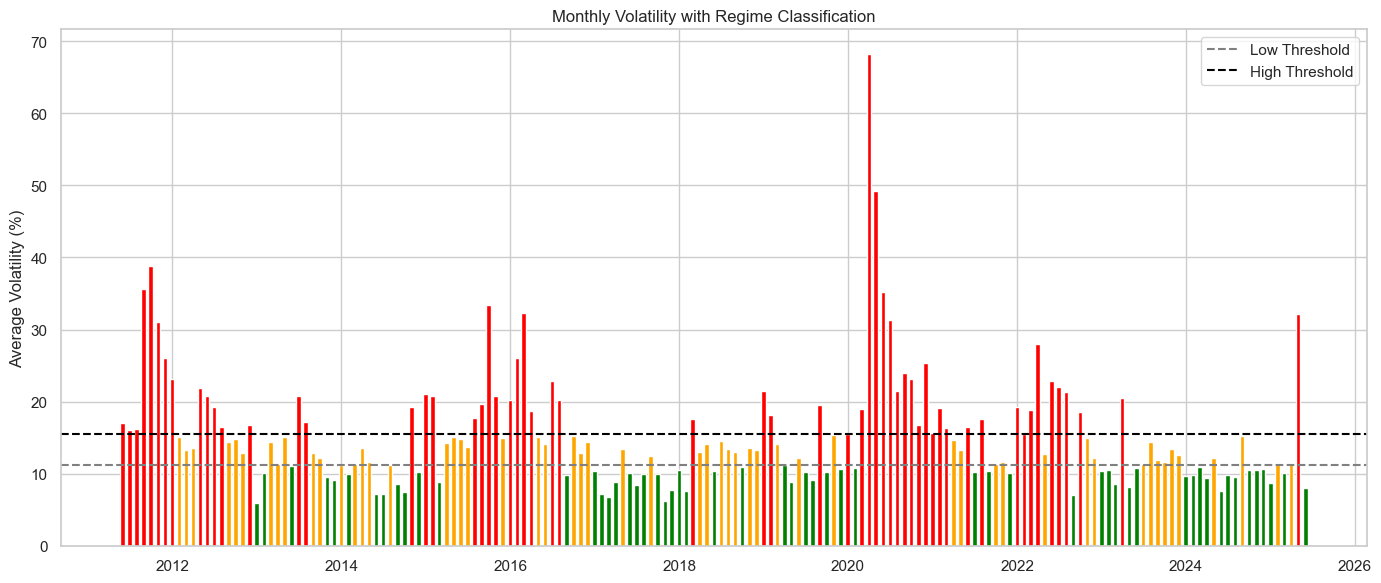

In [9]:
# Set datetime index
ftse_d.set_index('date', inplace=True)

# Resample volatility to monthly frequency and compute the average
monthly_volatility = ftse_d['volatility'].resample('M').mean()

# Define thresholds for volatility regimes using quantiles
low_threshold = monthly_volatility.quantile(0.33)
high_threshold = monthly_volatility.quantile(0.66)

# Classify regimes
def classify_regime(vol):
    if pd.isna(vol):
        return 'unknown'
    elif vol < low_threshold:
        return 'calm'
    elif vol > high_threshold:
        return 'crisis'
    else:
        return 'neutral'

monthly_regime = monthly_volatility.apply(classify_regime)
monthly_regime.name = 'market_regime'

# Combine with volatility for inspection
regime_df = pd.DataFrame({'volatility': monthly_volatility, 'market_regime': monthly_regime})

# Plot monthly volatility with regime classification colours
fig, ax = plt.subplots(figsize=(14, 6))
colors = {'calm': 'green', 'neutral': 'orange', 'crisis': 'red', 'unknown': 'grey'}
regime_colors = monthly_regime.map(colors)

ax.bar(regime_df.index, regime_df['volatility'], color=regime_colors, width=20)
ax.axhline(low_threshold, color='grey', linestyle='--', label='Low Threshold')
ax.axhline(high_threshold, color='black', linestyle='--', label='High Threshold')
ax.set_title('Monthly Volatility with Regime Classification')
ax.set_ylabel('Average Volatility (%)')
ax.legend()
plt.tight_layout()
plt.show()


## Merging the volatility data to the main_df

In [10]:
# First, reset index and create 'month' column from it
regime_df_reset = regime_df.reset_index()
regime_df_reset['month'] = regime_df_reset['date'].dt.to_period('M').dt.to_timestamp()

# Ensure maindf also has a datetime 'month' column
maindf['month'] = pd.to_datetime(maindf['month'])

# Now perform the merge
maindf_merged = pd.merge(maindf, regime_df_reset[['month', 'volatility', 'market_regime']],
                         on='month', how='left')

# Fill forward missing values
maindf_merged[['volatility', 'market_regime']] = maindf_merged[['volatility', 'market_regime']].ffill()


In [11]:
# Preview result
maindf_merged[['month', 'date', 'volatility', 'market_regime']].head(10)

,month,date,volatility,market_regime
0,2015-01-01,2015-01-20,20.741483,crisis
1,2015-01-01,2015-01-22,20.741483,crisis
2,2015-01-01,2015-01-22,20.741483,crisis
3,2015-01-01,2015-01-23,20.741483,crisis
4,2015-01-01,2015-01-26,20.741483,crisis
5,2015-01-01,2015-01-28,20.741483,crisis
6,2015-01-01,2015-01-29,20.741483,crisis
7,2015-02-01,2015-02-11,8.896513,calm
8,2015-02-01,2015-02-17,8.896513,calm
9,2015-02-01,2015-02-24,8.896513,calm


In [12]:
# maindf_merged.to_csv('maindf_merged.csv')

## Analysing Lagged Sentiment correlations

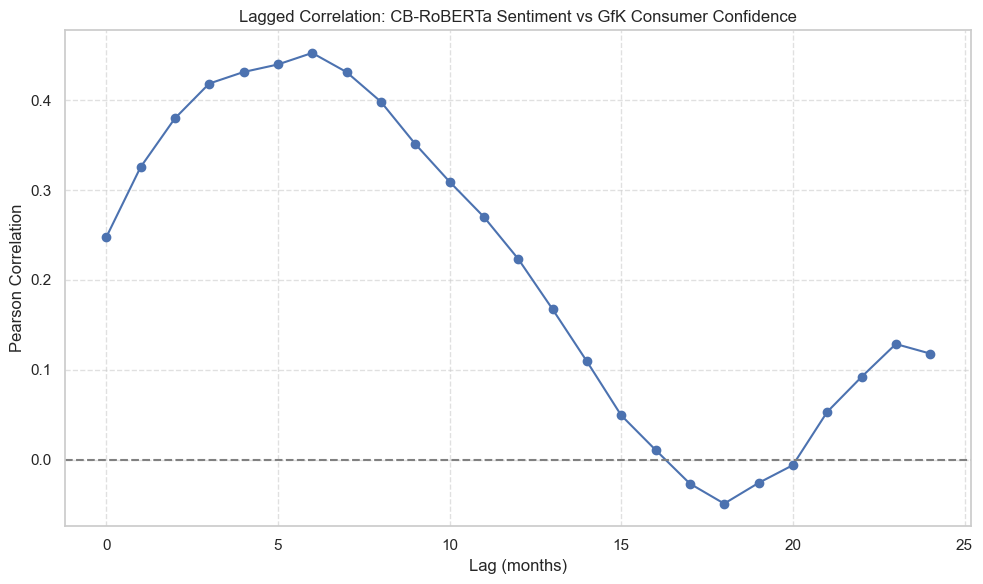

In [13]:
# Ensure 'date' is in datetime format and set as index (required by compute_correlation function)
maindf_merged['date'] = pd.to_datetime(maindf_merged['date'])  # in case it's not already
maindf_merged.set_index('date', inplace=True)


# Select the relevant series and run lag analysis
sentiment_series = maindf_merged['cbroberta_avg_score'].resample('M').mean()
indicator_series = maindf_merged['gfk_cc'].resample('M').mean()

lag_results = test_lag(sentiment_series, indicator_series, smoothing_window=6, max_lag=24, step=1)

# Plotting the correlation values across different lags
plt.figure(figsize=(10, 6))
plt.plot(lag_results['lag_months'], lag_results['correlation'], marker='o', linestyle='-')
plt.axhline(0, color='grey', linestyle='--')
plt.title('Lagged Correlation: CB-RoBERTa Sentiment vs GfK Consumer Confidence')
plt.xlabel('Lag (months)')
plt.ylabel('Pearson Correlation')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig(figures_path + 'GF_GfK modelling_Volat analysis_01.jpg')
plt.show()


### Notes:
The plot clearly shows that the correlation between CB-RoBERTa sentiment and GfK Consumer Confidence peaks at a 6-month lag, then gradually declines—confirming a strong forward-looking effect that weakens after about a year.

## Creating the Lagged sentiments

In [14]:
maindf_merged['finbert_score_lag6'] = maindf_merged['finbert_score'].shift(6)
maindf_merged['cbroberta_avg_score_lag6'] = maindf_merged['cbroberta_avg_score'].shift(6)

# Apply 6-month rolling avg
maindf_merged['finbert_score_smooth'] = maindf_merged['finbert_score_lag6'].rolling(24, min_periods=1).mean()
maindf_merged['cbroberta_avg_score_smooth'] = maindf_merged['cbroberta_avg_score_lag6'].rolling(24, min_periods=1).mean()


## Plotting the Relationship between GfK and Sentiment

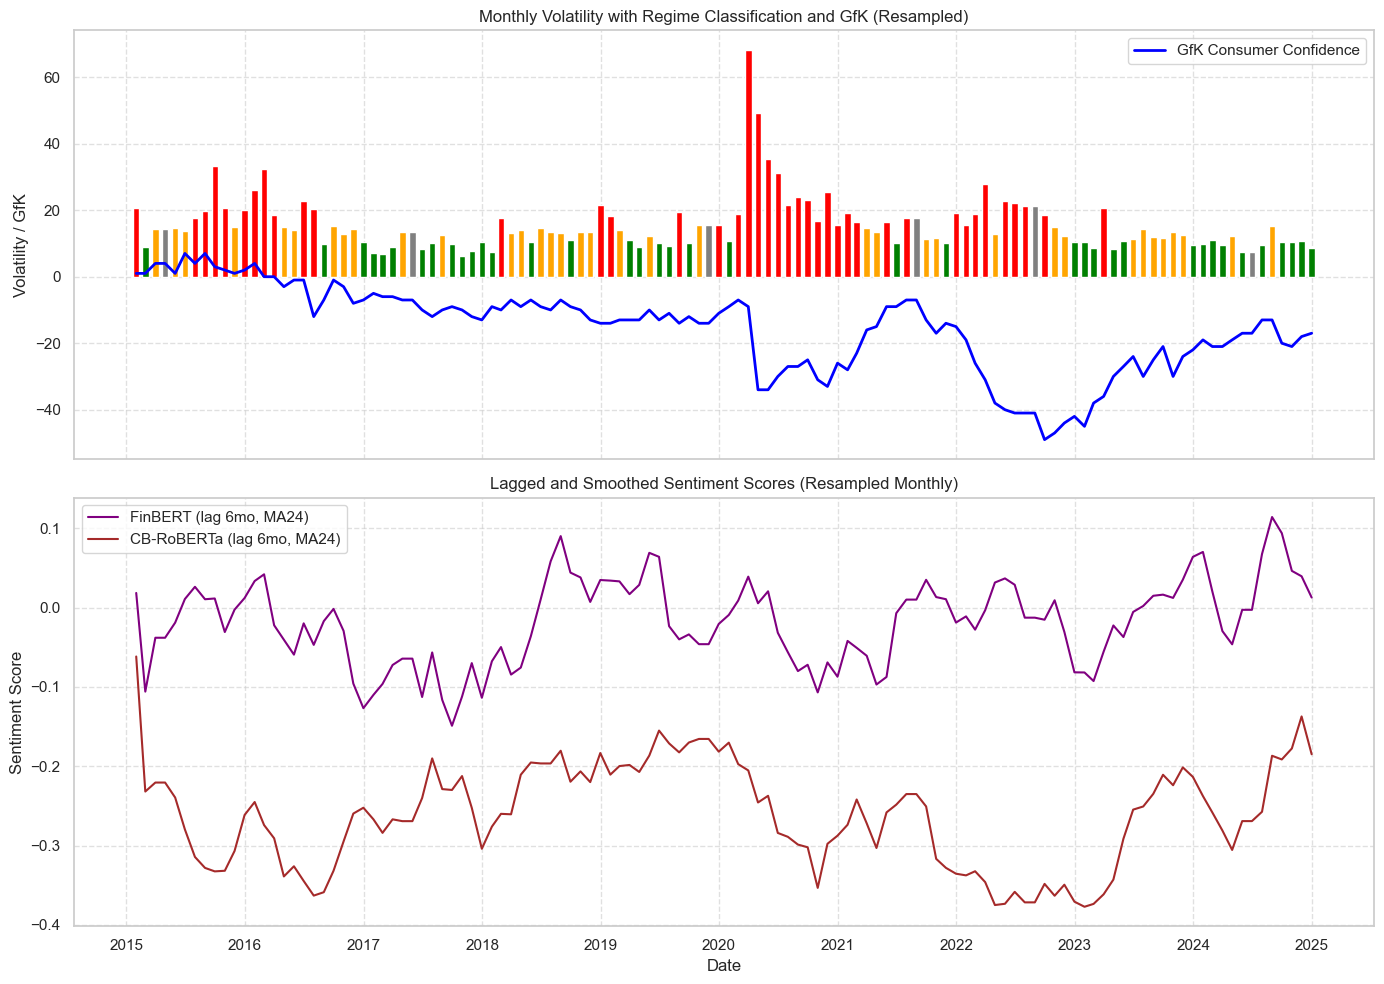

In [27]:
# Resample to monthly (smoother graph)
monthly_numeric = maindf_merged.select_dtypes(include='number').resample('M').mean()
monthly_categorical = maindf_merged[['market_regime']].resample('M').first()
monthly_df = pd.concat([monthly_numeric, monthly_categorical], axis=1)

# Forward Fill for months with no speeches
monthly_df['gfk_cc'] = monthly_df['gfk_cc'].ffill()
monthly_df['volatility'] = monthly_df['volatility'].ffill()
monthly_df['finbert_score_smooth'] = monthly_df['finbert_score_smooth'].ffill()
monthly_df['cbroberta_avg_score_smooth'] = monthly_df['cbroberta_avg_score_smooth'].ffill()


# Regime colours
regime_colors = monthly_df['market_regime'].map({
    'calm': 'green',
    'neutral': 'orange',
    'crisis': 'red'
}).fillna('grey')

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Top plot
ax1.bar(monthly_df.index, monthly_df['volatility'], color=regime_colors, width=20)
ax1.plot(monthly_df.index, monthly_df['gfk_cc'], color='blue', label='GfK Consumer Confidence', linewidth=2)
ax1.set_title('Monthly Volatility with Regime Classification and GfK (Resampled)')
ax1.set_ylabel('Volatility / GfK')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)

# Bottom plot
ax2.plot(monthly_df.index, monthly_df['finbert_score_smooth'], label='FinBERT (lag 6mo, MA24)', color='purple')
ax2.plot(monthly_df.index, monthly_df['cbroberta_avg_score_smooth'], label='CB-RoBERTa (lag 6mo, MA24)', color='brown')
ax2.set_title('Lagged and Smoothed Sentiment Scores (Resampled Monthly)')
ax2.set_ylabel('Sentiment Score')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

plt.savefig(figures_path + 'GF_GfK modelling_Volat analysis_02.jpg')
plt.show()




### First Look Insights:
- **Consumer Confidence Drops in High Volatility (Crisis) Periods:** High market volatility is a clear signal of broader economic stress that feeds into public expectations.
- **Sentiment Scores Lead GfK Movements by Several Months:** In the bottom subplot, both FinBERT and CB-RoBERTa scores (lagged 6 months) show movements that appear to anticipate subsequent rises or falls in GfK
- **CB-RoBERTa's smoothed signal appears more consistent and less volatile than FinBERT.** It tracks GfK shifts with fewer erratic jumps.

This evidence supports a communication strategy that emphasises clear, confidence-building messages, especially when market signals are ambiguous. Leveraging sentiment analytics offers a quantifiable lens into how speech tone influences the public's economic outlook.


#
## Analising correlations with GfK

In [16]:
# resample to monthly: align granularity with the target (GfK)
monthly_features = maindf_merged.select_dtypes(include='number').resample('ME').mean()

# Drop columns with too many missing values
valid_monthly_features = monthly_features.loc[:, monthly_features.notnull().mean() > 0.5]

# Drop remaining rows with NaNs
valid_monthly_features = valid_monthly_features.dropna()

# Compute correlation with GfK
gfk_correlations = valid_monthly_features.corr()['gfk_cc'].drop('gfk_cc').sort_values(key=abs, ascending=False)

print(gfk_correlations.head(25))


infl_exp                     -0.764074
cbroberta_avg_score_smooth    0.690298
cpi_rate                     -0.661284
gbp_usd_m                     0.623279
rsi_3mo3m1y                   0.614309
mortgage_2yr                 -0.398180
avg_house_price              -0.391464
rsi_vol                       0.316856
mortgage_approvals            0.312237
pmi                           0.280592
cbroberta_avg_score_lag6      0.271543
is_gov                        0.245647
hpi_mom                       0.222997
government                    0.221918
unemp_rate                    0.221585
rsi_3mo3m                     0.201698
cbroberta_avg_score           0.174888
finbert_score_smooth          0.164756
topic_2                       0.163678
firms                         0.137996
finbert_confidence           -0.134570
hpi_yoy                      -0.127302
dominant_topic               -0.123022
topic_1                       0.114756
cbroberta_avg_sentiment       0.114454
Name: gfk_cc, dtype: floa

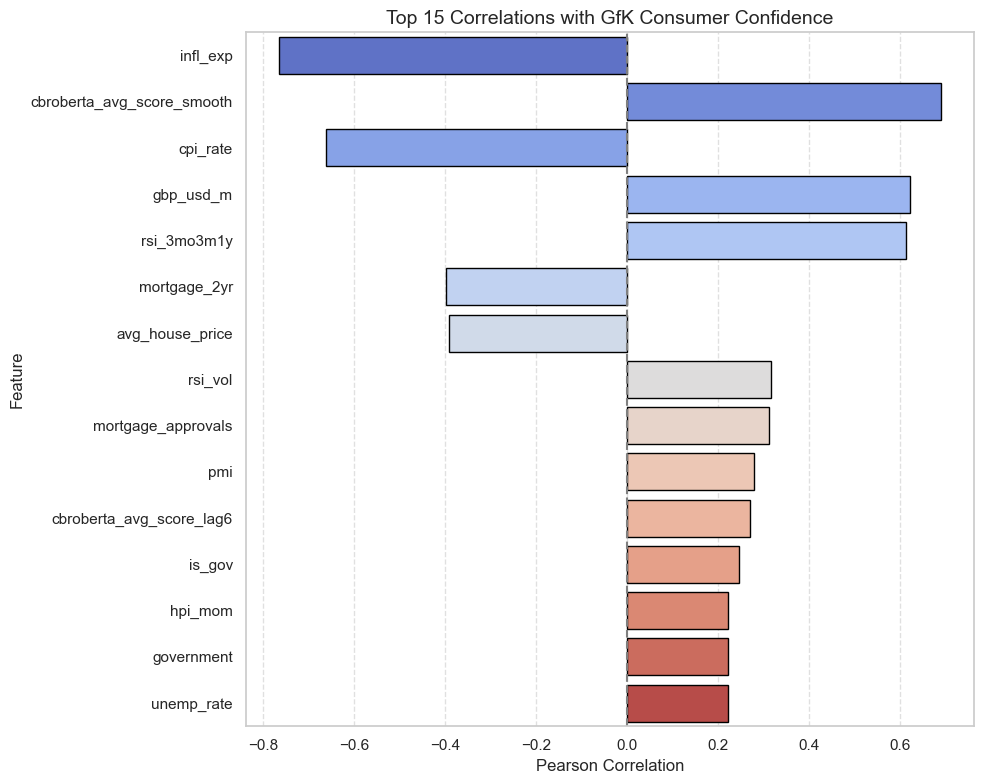

In [17]:
# Ensure correlations are in a DataFrame for plotting
gfk_corr_df = gfk_correlations.head(15).to_frame().reset_index()
gfk_corr_df.columns = ['Feature', 'Correlation']
gfk_corr_df['AbsCorrelation'] = gfk_corr_df['Correlation'].abs()

# Sort by absolute correlation in descending order (strongest at top)
gfk_corr_df = gfk_corr_df.sort_values(by='AbsCorrelation', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=gfk_corr_df, x='Correlation', y='Feature', palette='coolwarm', edgecolor='black')
plt.title('Top 15 Correlations with GfK Consumer Confidence', fontsize=14)
plt.xlabel('Pearson Correlation')
plt.ylabel('Feature')
plt.axvline(0, color='grey', linestyle='--')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig(figures_path + 'GF_GfK modelling_Volat analysis_03.jpg')
plt.show()



#
# Building MLR model
### Selecting relevant features

In [18]:
# Define feature set
feature_candidates = [
    'infl_exp',
    'cpi_rate',
    'unemp_rate',
    'rsi_3mo3m1y',
    'gbp_usd_m',
    'mortgage_approvals',
    'cbroberta_avg_score_lag6',
    'volatility'
]

# Drop rows with NaN in any of the selected features or the target
model_df = maindf_merged[feature_candidates + ['gfk_cc']].dropna()

# Prepare feature matrix
X = model_df[feature_candidates]

# Add constant for VIF calculation
X_with_const = sm.add_constant(X)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

vif_data.sort_values(by='VIF', ascending=False)

,Feature,VIF
0,const,515.817590
1,infl_exp,12.086859
2,cpi_rate,10.279303
5,gbp_usd_m,3.278573
3,unemp_rate,2.900813
4,rsi_3mo3m1y,2.423719
6,mortgage_approvals,2.388070
8,volatility,1.230691
7,cbroberta_avg_score_lag6,1.033511


### Note:
VIF values show very high multicollinearity between infl_exp and cpi_rate.  
Since infl_exp has a stronger correlation with GfK, and it's more forward-looking (expectations vs observed inflation), we'll drop cpi_rate and rerun VIF

In [19]:
# Define feature set
feature_candidates = [
    'infl_exp',
    'unemp_rate',
    'rsi_3mo3m1y',
    'gbp_usd_m',
    'mortgage_approvals',
    'cbroberta_avg_score_lag6',
    'volatility'
]

# Drop rows with NaN in any of the selected features or the target
model_df = maindf_merged[feature_candidates + ['gfk_cc']].dropna()

# Prepare feature matrix
X = model_df[feature_candidates]

# Add constant for VIF calculation
X_with_const = sm.add_constant(X)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

vif_data.sort_values(by='VIF', ascending=False)

,Feature,VIF
0,const,485.235266
4,gbp_usd_m,3.037992
2,unemp_rate,2.898852
1,infl_exp,2.610069
3,rsi_3mo3m1y,2.418380
5,mortgage_approvals,1.889381
7,volatility,1.109857
6,cbroberta_avg_score_lag6,1.031133


### Final features and target

In [20]:
features = [
    'infl_exp',
    'unemp_rate',
    'rsi_3mo3m1y',
    'gbp_usd_m',
    'mortgage_approvals',
    'cbroberta_avg_score_lag6',
    'volatility'
]

target = 'gfk_cc'

### Train / Test split

In [21]:
# Prepare the data
model_df = maindf_merged[features + [target]].dropna()
X = model_df[features]
y = model_df[target]

# Step 2: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [22]:
# Fit the model
mlr_model = LinearRegression()
mlr_model.fit(X_train, y_train)

# Predict
y_pred = mlr_model.predict(X_test)

# Evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Evaluation

print("Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared: {r2:.2f}")


Model Performance:
Mean Absolute Error (MAE): 2.77
R-squared: 0.78


In [23]:
# Coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': mlr_model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

Feature Importance (Linear Coefficients):
                    Feature  Coefficient
3                 gbp_usd_m    25.921876
0                  infl_exp    -7.702110
1                unemp_rate    -2.811245
5  cbroberta_avg_score_lag6    -0.977877
2               rsi_3mo3m1y     0.592405
4        mortgage_approvals    -0.173022
6                volatility    -0.110917


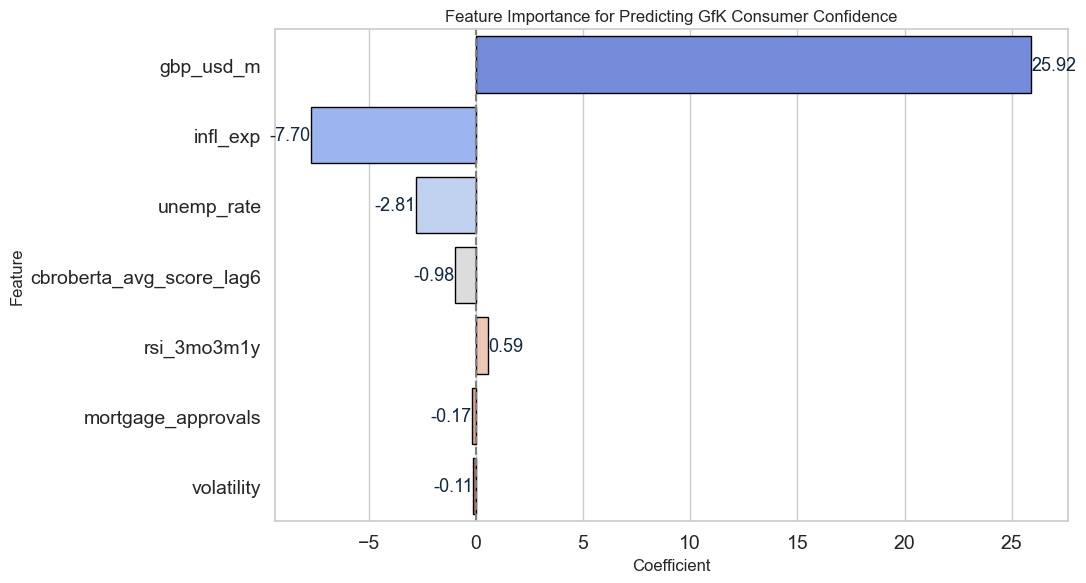

In [24]:
# Plot the coefficients
plot_feature_importance(X, mlr_model, save_path=figures_path, title='Feature Importance for Predicting GfK Consumer Confidence')

### Evaluation of the model:
- The model explains **78% of the variance in GfK Consumer Confidence, with an average prediction error of about 2.77 points.**
- GBP/USD is the most powerful predictor, with inflation expectations in second place.
- cbroberta_avg_score_lag6, adds value to the model as a booster for interpretability.

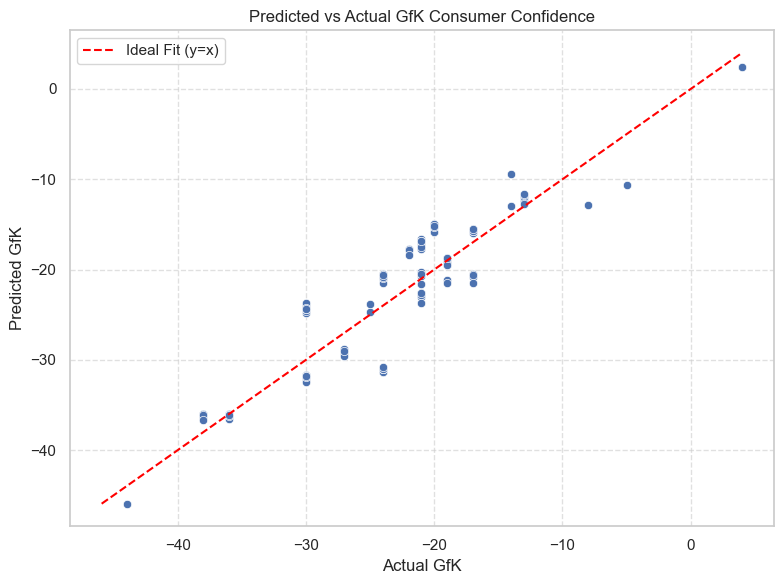

In [25]:
# Create a DataFrame to compare actual and predicted values
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Actual', y='Predicted', data=comparison_df)
plt.plot([comparison_df.min().min(), comparison_df.max().max()],
         [comparison_df.min().min(), comparison_df.max().max()],
         color='red', linestyle='--', label='Ideal Fit (y=x)')
plt.title('Predicted vs Actual GfK Consumer Confidence')
plt.xlabel('Actual GfK')
plt.ylabel('Predicted GfK')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

plt.savefig(figures_path + 'GF_GfK modelling_Volat analysis_05.jpg')
plt.show()


#
## Testing the model in High vs neutral and low volatility months

In [26]:
# Copy the clean dataset used for modeling and add 'market_regime'
model_df = maindf_merged[features + [target, 'market_regime']].dropna()

# Segment data by volatility regime
results_by_regime = {}

for regime in ['crisis', 'neutral', 'calm']:
    subset = model_df[model_df['market_regime'] == regime]
    
    if len(subset) < 10:
        continue  # skip if too few samples
    
    X_sub = subset[features]
    y_sub = subset[target]
    
    # Split (no shuffle to preserve timeline consistency)
    X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.2, shuffle=False)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results_by_regime[regime] = {'MAE': mae, 'R2': r2, 'n_samples': len(subset)}

results_by_regime_df = pd.DataFrame(results_by_regime).T
results_by_regime_df.index.name = 'Volatility Regime'
results_by_regime_df.reset_index(inplace=True)


results_by_regime_df


,Volatility Regime,MAE,R2,n_samples
0,crisis,7.348943,-1.013763,204.0
1,neutral,3.656209,0.447694,234.0
2,calm,4.634563,-0.116240,219.0


### Interpretation:
- Neutral periods have more predictable structure.
- **Negative R2:** During crisis periods, consumer sentiment can shift abruptly due to shocks not captured by the features (e.g. news, extreme market moves, etc)
- In calm periods, GfK might not move much, making it hard for the model to capture signal (minor shifts become hard to predict, and noise dominates).

# Final Conclusions:
- **Speech sentiment (especially CB-RoBERTa) has predictive value for GfK confidence, especially applying a 6-month lag.**
- **Account for volatility:** Be mindful of the model's limitations in extreme high/low volatility periods.
- **Add short-term features:** like 1-month speech sentiment changes, media sentiment, or volatility delta to capture rapid swings.
- **Switch to more complex models:** like XGBoost to explore non-linear effects, or SARIMAX to use auto-regression and capture shifts short-term timeframes.